## Linear Regression

Generate linear-looking data with Gaussian noise

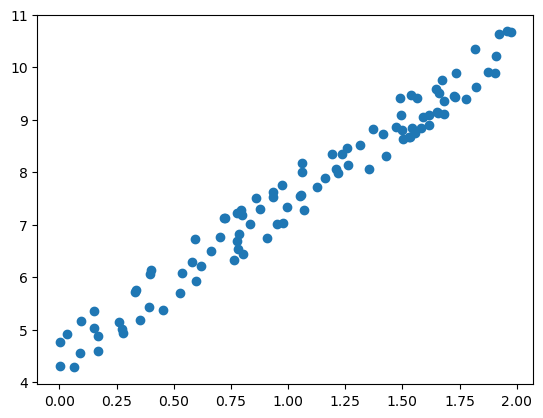

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

plt.scatter(X, y)

Let's compute the value of theta that minimizes the MSE cost function using the <b>Normal Equation</b>

In [10]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print(theta_best)

[[4.52152292]
 [2.94210153]]


In [11]:
X_new = np.array([[0], [2]])

X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.52152292],
       [10.40572598]])

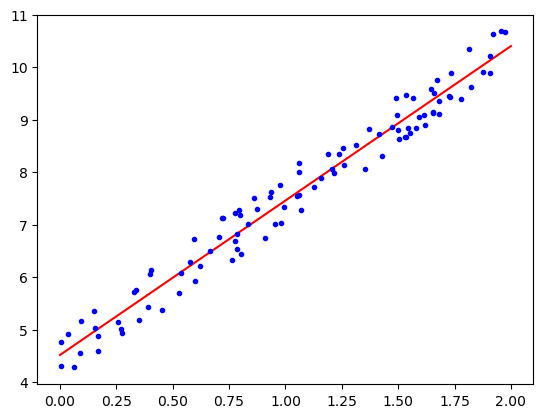

In [14]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

Performing linear regression using Scikit-Learn is quite simple

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.52152292]), array([[2.94210153]]))

In [16]:
lin_reg.predict(X_new)

array([[ 4.52152292],
       [10.40572598]])

The LinearRegression class is based on the scipy.linalg.lstsq() function, which computes the dot product of Moore-Penrose <i>pseudoinverse</i> of X with y to get the optimal theta

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.52152292],
       [2.94210153]])

np.linalg.pinv() can be used to compute the pseudoinverse directly

In [19]:
np.linalg.pinv(X_b).dot(y)

array([[4.52152292],
       [2.94210153]])

The pseudoinverse itself is computed using <b>Singular Value Decomposition</b>

This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely

## Gradient Descent